# OCRD - A 1st Overview 

## Imports

In [329]:
import imghdr
import os
from pathlib import PosixPath
import re
from tqdm import tqdm_notebook
from zipfile import ZipFile
import xml.etree.ElementTree as ET

from PIL import ImageDraw
from display_xml import XML
from fastai.vision import *
import seaborn as sns
from shapely.geometry import Polygon as ShapelyPolygon

!mkdir -p ../input
BAGS = PosixPath(os.path.expanduser('~/Dropbox/0bags'))
INPUT = PosixPath('../input/')

RESIZE_FACTOR = 8  # 1/8th of the original images should be good enough to get a first idea
INPUT_RESIZED = PosixPath(f'../downscale_to_{RESIZE_FACTOR}th')

MASKS = PosixPath('../masks')
MASKS_RESIZED = PosixPath(f'../masks_downscale_to{RESIZE_FACTOR}th')

## Unzip Input data from the (dropbox) folder

In [93]:
zip_archives = BAGS.ls()
print(zip_archives[:5], len(zip_archives))
!du -sh ~/Dropbox/0bags

[PosixPath('/home/janek/Dropbox/0bags/stein_verwaltungslehre07_1868.zip'), PosixPath('/home/janek/Dropbox/0bags/buesch_handlung01_1792.zip'), PosixPath('/home/janek/Dropbox/0bags/brunner_rechtsgeschichte01_1887.zip'), PosixPath('/home/janek/Dropbox/0bags/karsch_gedichte_1792.zip'), PosixPath('/home/janek/Dropbox/0bags/steinen_naturvoelker_1894.zip')] 211
2,9G	/home/janek/Dropbox/0bags


In [96]:
for f in tqdm_notebook(filter(lambda f: f.name.endswith('.zip'), BAGS.ls())):
    dest = INPUT / f.name.replace('.zip', '')
    ZipFile(f, 'r').extractall(dest)

## Give image files a .jpeg or whatever suffix

fastai atm needs it to work correctly (but it's also a nice check of the data integrity, too)

In [4]:
imgfiles = []
imgtypes = set()

for root, dirs, files in os.walk(INPUT):
    path = PosixPath(root)
    if path.name != "OCR-D-IMG": continue
    for imgf in [PosixPath(f) for f in files]:
        if not imgf.suffix:
            imgtype = imghdr.what(path / imgf.name)
            file_with_jpeg_or_whatever = path/(imgf.name + "." + imgtype)
            os.rename(path / imgf, file_with_jpeg_or_whatever)
            imgf = file_with_jpeg_or_whatever
        imgtypes.add(imgf.suffix)
        imgfiles.append((path / imgf).relative_to(INPUT))
print("Found image files", imgfiles[:5], "...", imgfiles[-5:])
print("Found image types", imgtypes)

Found image files [PosixPath('fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg'), PosixPath('fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0014.jpeg'), PosixPath('fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0013.jpeg'), PosixPath('fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg'), PosixPath('fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0012.jpeg')] ... [PosixPath('mohr_fachwerk02_1875/data/OCR-D-IMG/OCR-D-IMG_0006.jpeg'), PosixPath('mohr_fachwerk02_1875/data/OCR-D-IMG/OCR-D-IMG_0001.jpeg'), PosixPath('mohr_fachwerk02_1875/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg'), PosixPath('gerber_staatsrecht_1865/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg'), PosixPath('dahlmann_politik_1835/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg')]
Found image types {'.jpeg'}


## Get an overview of original resolutions

In [22]:
image_df = pd.DataFrame({
    "orig": imgfiles, 
    "res": [PIL.Image.open(INPUT / file).size for file in imgfiles],
})
image_df["width"] = image_df.res.apply(lambda t: t[0])
image_df["height"] = image_df.res.apply(lambda t: t[1])
image_df["ratio"] = image_df.height / image_df.width

pd.set_option('max_colwidth', 120)
image_df.head()

,orig,res,width,height,ratio
0,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg,"(2724, 3578)",2724,3578,1.31351
1,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0014.jpeg,"(2724, 3578)",2724,3578,1.31351
2,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0013.jpeg,"(2724, 3578)",2724,3578,1.31351
3,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg,"(2724, 3578)",2724,3578,1.31351
4,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0012.jpeg,"(2724, 3578)",2724,3578,1.31351


In [273]:
res_count = image_df.groupby(["width", "height"]).count().sort_values("orig", ascending=False).reset_index()
res_count.head()

,width,height,orig,res,ratio,ann
0,2486,3404,105,105,105,105
1,1560,2241,20,20,20,20
2,2328,3177,19,19,19,19
3,1611,2421,19,19,19,19
4,1563,2304,14,14,14,14


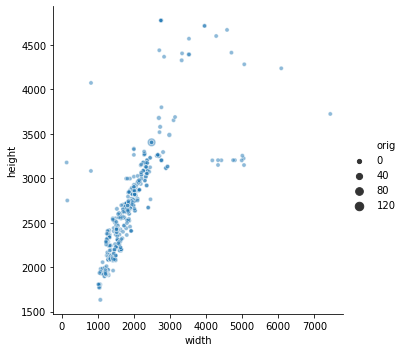

In [107]:
sns.relplot(x="width", y="height", size="orig", data=res_count, alpha=0.5)

## Resize images

In [300]:
def manipulate_images_(orig_folder: PathLike, dest_folder: PathLike, manipulate_: Callable, overwrite: bool = False):
    orig_folder = pathify(orig_folder)
    dest_folder = pathify(dest_folder)
    for file in tqdm_notebook(imgfiles):
        if overwrite or not (dest_folder / file).exists():
            os.makedirs((dest_folder / file).parent, exist_ok=True)
            manipulate_(orig_folder / file, dest_folder / file)

In [239]:
def resize_image_(orig: PosixPath, dest: PosixPath):
    img = open_image(orig)
    img.resize((img.shape[0], img.shape[1] // RESIZE_FACTOR, img.shape[2] // RESIZE_FACTOR))
    img.save(dest)
    
manipulate_images_(INPUT, INPUT_RESIZED, resize_image_)

## Look at segment annotations

In [41]:
PathLike = Union[str, PosixPath]

def pathify(p: PathLike) -> PosixPath:
    return PosixPath(p) if not type(p) is PosixPath else p 

def ann_path(img_path: PathLike) -> PosixPath:
    img_path = pathify(img_path)
    page = re.search(r'_(\d+)', img_path.name).group(1)
    p = img_path.parent.parent / "OCR-D-GT-SEG-BLOCK" / f"OCR-D-GT-SEG-BLOCK_{page}"
    assert (INPUT / p).exists(), f"did not found a file for segmentation path {p} for img {img_path}"
    return p

In [42]:
image_df["ann"] = image_df.orig.apply(ann_path)
image_df.head()

,orig,res,width,height,ratio,ann
0,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg,"(2724, 3578)",2724,3578,1.31351,fischer_werkzeugmaschinen01_1900/data/OCR-D-GT-SEG-BLOCK/OCR-D-GT-SEG-BLOCK_0011
1,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0014.jpeg,"(2724, 3578)",2724,3578,1.31351,fischer_werkzeugmaschinen01_1900/data/OCR-D-GT-SEG-BLOCK/OCR-D-GT-SEG-BLOCK_0014
2,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0013.jpeg,"(2724, 3578)",2724,3578,1.31351,fischer_werkzeugmaschinen01_1900/data/OCR-D-GT-SEG-BLOCK/OCR-D-GT-SEG-BLOCK_0013
3,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg,"(2724, 3578)",2724,3578,1.31351,fischer_werkzeugmaschinen01_1900/data/OCR-D-GT-SEG-BLOCK/OCR-D-GT-SEG-BLOCK_0009
4,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0012.jpeg,"(2724, 3578)",2724,3578,1.31351,fischer_werkzeugmaschinen01_1900/data/OCR-D-GT-SEG-BLOCK/OCR-D-GT-SEG-BLOCK_0012


In [114]:
def ann_xml(p: PathLike) -> str:
    xmlstr = "\n".join(open(INPUT / pathify(p)).readlines())
    xmlstr = re.sub(' xmlns[:\w]*="[^"]+"', '', xmlstr, count=1)  # get rid of the freaking xmlns
    return xmlstr

In [144]:
img_path_example = image_df.orig.values[0]
ann_path_example = image_df.ann.values[0]

In [116]:
XML(ann_xml(ann_path_example).encode("ascii"))

Looks like we need all the Coords and the parent object contains the segment label Node (+ type if available)

In [334]:
l = [1, 2, 3, 4]
[(x, y) for x, y in zip(l[::2], l[1::2])]

[(1, 2), (3, 4)]

In [363]:
def points2poly(points: str) -> ShapelyPolygon:
    xy_int = [int(p) for p in points.split(" ")]
    return ShapelyPolygon([(x, y) for x, y in zip(xy_int[::2], xy_int[1::2])])

def segments(path: Union[str, PosixPath]) -> List[Dict[str, str]]:
    """ Return dict with pathname, segment label and points 
    
    Arguments:
        path  Can be either image or annotation file path
    """
    
    segs = []
    xml = ET.fromstring(ann_xml(ann_path(path)))
    for segment in xml.findall(".//Coords/.."):
        region_type = segment.attrib.get("type", "")
        if region_type: region_type = "-" + region_type
        label = segment.tag + region_type
        points = segment.find("Coords").attrib["points"]
        points = points.replace(',', ' ')
        segs.append({"path": path, "label": label, "points": points})
        
    for segment in segs:
        poly = points2poly(segment["points"])
        not_a_container = True
        for other_segment in segs:
            if other_segment == segment: continue
            other_poly = points2poly(other_segment["points"])
            if other_poly.within(poly):
                not_a_container = False
                break
        segment["is_node"] = not_a_container

    return segs

### Segmentation data frame

In [364]:
segments_df = pd.concat([pd.DataFrame(segments(f)) for f in imgfiles])
segments_df.head()

,path,label,points,is_node
0,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg,Border,2208 3426 2208 252 0 252 0 3426,False
1,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg,TextRegion-header,516 446 1471 446 1471 536 516 536,True
2,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg,TextRegion-page-number,1663 460 1772 460 1772 539 1663 539,True
3,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg,GraphicRegion,1283 1246 1633 1246 1633 1725 1283 1725,True
4,fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg,GraphicRegion,430 1260 785 1260 785 1782 430 1782,True


In [365]:
segments_df.label.value_counts()

TextRegion-paragraph                    3167
Border                                  1108
TextRegion-page-number                   851
SeparatorRegion                          495
TextRegion-heading                       399
TextRegion-footnote                      351
TextRegion-header                        332
GraphicRegion                            220
TextRegion-signature-mark                215
TableRegion                              198
TextRegion-caption                       153
TextRegion-catch-word                    135
MathsRegion                              135
GraphicRegion-barcode                    103
TextRegion-footnote-continued             81
TextRegion-marginalia                     38
GraphicRegion-handwritten-annotation      28
TextRegion-endnote                        28
GraphicRegion-stamp                       27
TextRegion-other                          23
NoiseRegion                               21
TextRegion-drop-capital                   13
PrintSpace

### Segments containing other segments

Will need a domain export on how to proceed with this info
Right now, I'll only process node segmentations.

In [366]:
pd.crosstab(segments_df.label, segments_df.is_node)

is_node,False,True
label,,
Border,1095,13
GraphicRegion,2,218
GraphicRegion-barcode,0,103
GraphicRegion-decoration,0,1
GraphicRegion-handwritten-annotation,0,28
GraphicRegion-other,0,5
GraphicRegion-stamp,0,27
MathsRegion,0,135
NoiseRegion,0,21


In [367]:
# reserve label 0 for background
classes = {l: c for c, l in enumerate(segments_df.label.unique(), start=1)}  
# Add an extra class to have a separation between segments (as discussed with Uwe)
classes["ArtificialBorder"] = len(classes)
classes

{'Border': 1,
 'TextRegion-header': 2,
 'TextRegion-page-number': 3,
 'GraphicRegion': 4,
 'TextRegion-caption': 5,
 'TextRegion-paragraph': 6,
 'MathsRegion': 7,
 'TextRegion-footnote': 8,
 'TextRegion-heading': 9,
 'GraphicRegion-barcode': 10,
 'TableRegion': 11,
 'SeparatorRegion': 12,
 'TextRegion-signature-mark': 13,
 'TextRegion-footnote-continued': 14,
 'TextRegion-catch-word': 15,
 'GraphicRegion-handwritten-annotation': 16,
 'GraphicRegion-stamp': 17,
 'TextRegion-endnote': 18,
 'TextRegion-drop-capital': 19,
 'TextRegion-other': 20,
 'PrintSpace': 21,
 'NoiseRegion': 22,
 'GraphicRegion-other': 23,
 'TextRegion-marginalia': 24,
 'GraphicRegion-decoration': 25,
 'ArtificialBorder': 25}

### Question to the domain experts: What's the difference betweeing a heading and a header?

Also ToDo:
- Check and display all the different Segment types whether they are reasonable with a domain expert
- Check whether they overlap

## Create segmentation mask images

In [368]:
classes

{'Border': 1,
 'TextRegion-header': 2,
 'TextRegion-page-number': 3,
 'GraphicRegion': 4,
 'TextRegion-caption': 5,
 'TextRegion-paragraph': 6,
 'MathsRegion': 7,
 'TextRegion-footnote': 8,
 'TextRegion-heading': 9,
 'GraphicRegion-barcode': 10,
 'TableRegion': 11,
 'SeparatorRegion': 12,
 'TextRegion-signature-mark': 13,
 'TextRegion-footnote-continued': 14,
 'TextRegion-catch-word': 15,
 'GraphicRegion-handwritten-annotation': 16,
 'GraphicRegion-stamp': 17,
 'TextRegion-endnote': 18,
 'TextRegion-drop-capital': 19,
 'TextRegion-other': 20,
 'PrintSpace': 21,
 'NoiseRegion': 22,
 'GraphicRegion-other': 23,
 'TextRegion-marginalia': 24,
 'GraphicRegion-decoration': 25,
 'ArtificialBorder': 25}

In [379]:
Width = int
Height = int
Resolution = Tuple[Width, Height]
PointsXY = Union[str, List[int]]

def xyfy(p: PointsXY) -> List[int]:
    return [int(xy) for xy in p.split(" ")] if type(p) is str else p

def create_mask_(
    orig_path: PathLike, dest_path: PathLike,
    classes: Dict[str, int], 
    border: str = "ArtificialBorder", border_width: int = 5,  # XXX(js): no idea about a good border_width
    downscale: int = 1,
    only_nodes: bool = True,
):
    dest_path = pathify(dest_path)
    res = PIL.Image.open(orig_path).size
    img = PIL.Image.new(
        mode='L',  # only one 8bit channel (we'll encode the segmentation classes as one-hot)
        size=(res[0] // downscale, res[1] // downscale), 
        color=0
    )
    segs = segments(orig_path)
    if only_nodes: segs = [s for s in segs if s["is_node"]]
    for s in segs:
        s["points"] = [p // downscale for p in xyfy(s["points"])]
        PIL.ImageDraw.Draw(img).polygon(s["points"], fill=classes[s["label"]])
        
    # Also draw artificial borders but after the filled polygon to not get hidden by any overlapping stuff
    for s in segs:
        points = s["points"]
        points += [points[0], points[1]]  # necessary to close the lining (it's not autoclosed like for polygonals)
        PIL.ImageDraw.Draw(img).line(points, fill=classes[border], width=border_width)
    img.save(dest_path)

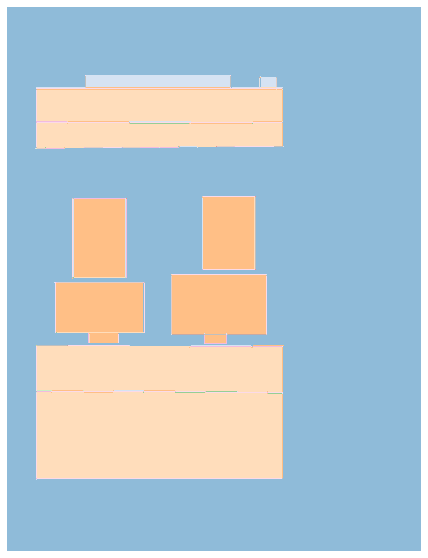

In [370]:
res = image_df.res.values[0]
points = segments(image_df.orig.values[0])[0]["points"]
create_mask_(INPUT / img_path_example, "/tmp/foo.jpg", classes)
seg = open_mask("/tmp/foo.jpg")
seg.show(figsize=(10, 10))

In [382]:
manipulate_images_(
    INPUT, MASKS_RESIZED, 
    partial(create_mask_, classes=classes, downscale=RESIZE_FACTOR, only_nodes=False),
    overwrite=True,
)

## Read image list

In [383]:
size = np.floor_divide(
    res_count[["width", "height"]].values[0], RESIZE_FACTOR
).tolist()
print("Normalize all image with resize to", size)
def get_y_fn(img_path: PathLike) -> PosixPath:
    img_path = pathify(img_path)
    return MASKS_RESIZED / img_path.relative_to(INPUT_RESIZED) 

imglist = (SegmentationItemList
    .from_folder(INPUT_RESIZED)
    .split_by_rand_pct()
    .label_from_func(get_y_fn, classes=classes)
    .transform([], size=size, tfm_y=True)
    .databunch()
)
imglist

Normalize all image with resize to [310, 425]


ImageDataBunch;

Train: LabelList (915 items)
x: SegmentationItemList
Image (3, 310, 425),Image (3, 310, 425),Image (3, 310, 425),Image (3, 310, 425),Image (3, 310, 425)
y: SegmentationLabelList
ImageSegment (1, 310, 425),ImageSegment (1, 310, 425),ImageSegment (1, 310, 425),ImageSegment (1, 310, 425),ImageSegment (1, 310, 425)
Path: ../downscale_to_8th;

Valid: LabelList (228 items)
x: SegmentationItemList
Image (3, 310, 425),Image (3, 310, 425),Image (3, 310, 425),Image (3, 310, 425),Image (3, 310, 425)
y: SegmentationLabelList
ImageSegment (1, 310, 425),ImageSegment (1, 310, 425),ImageSegment (1, 310, 425),ImageSegment (1, 310, 425),ImageSegment (1, 310, 425)
Path: ../downscale_to_8th;

Test: None

In [384]:
imglist.items

array([PosixPath('../downscale_to_8th/fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg'),
       PosixPath('../downscale_to_8th/fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0014.jpeg'),
       PosixPath('../downscale_to_8th/fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0013.jpeg'),
       PosixPath('../downscale_to_8th/fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg'), ...,
       PosixPath('../downscale_to_8th/mohr_fachwerk02_1875/data/OCR-D-IMG/OCR-D-IMG_0001.jpeg'),
       PosixPath('../downscale_to_8th/mohr_fachwerk02_1875/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg'),
       PosixPath('../downscale_to_8th/gerber_staatsrecht_1865/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg'),
       PosixPath('../downscale_to_8th/dahlmann_politik_1835/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg')], dtype=object)

## Look to some images

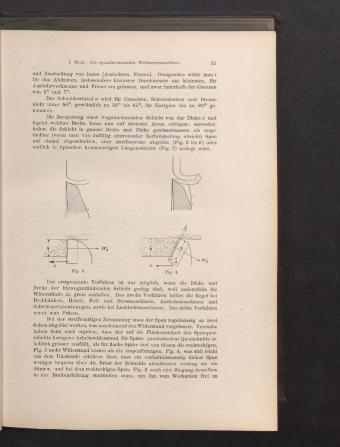

In [385]:
imglist.x[0]

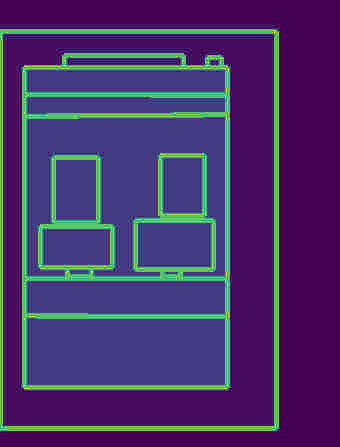

In [386]:
imglist.y[0]

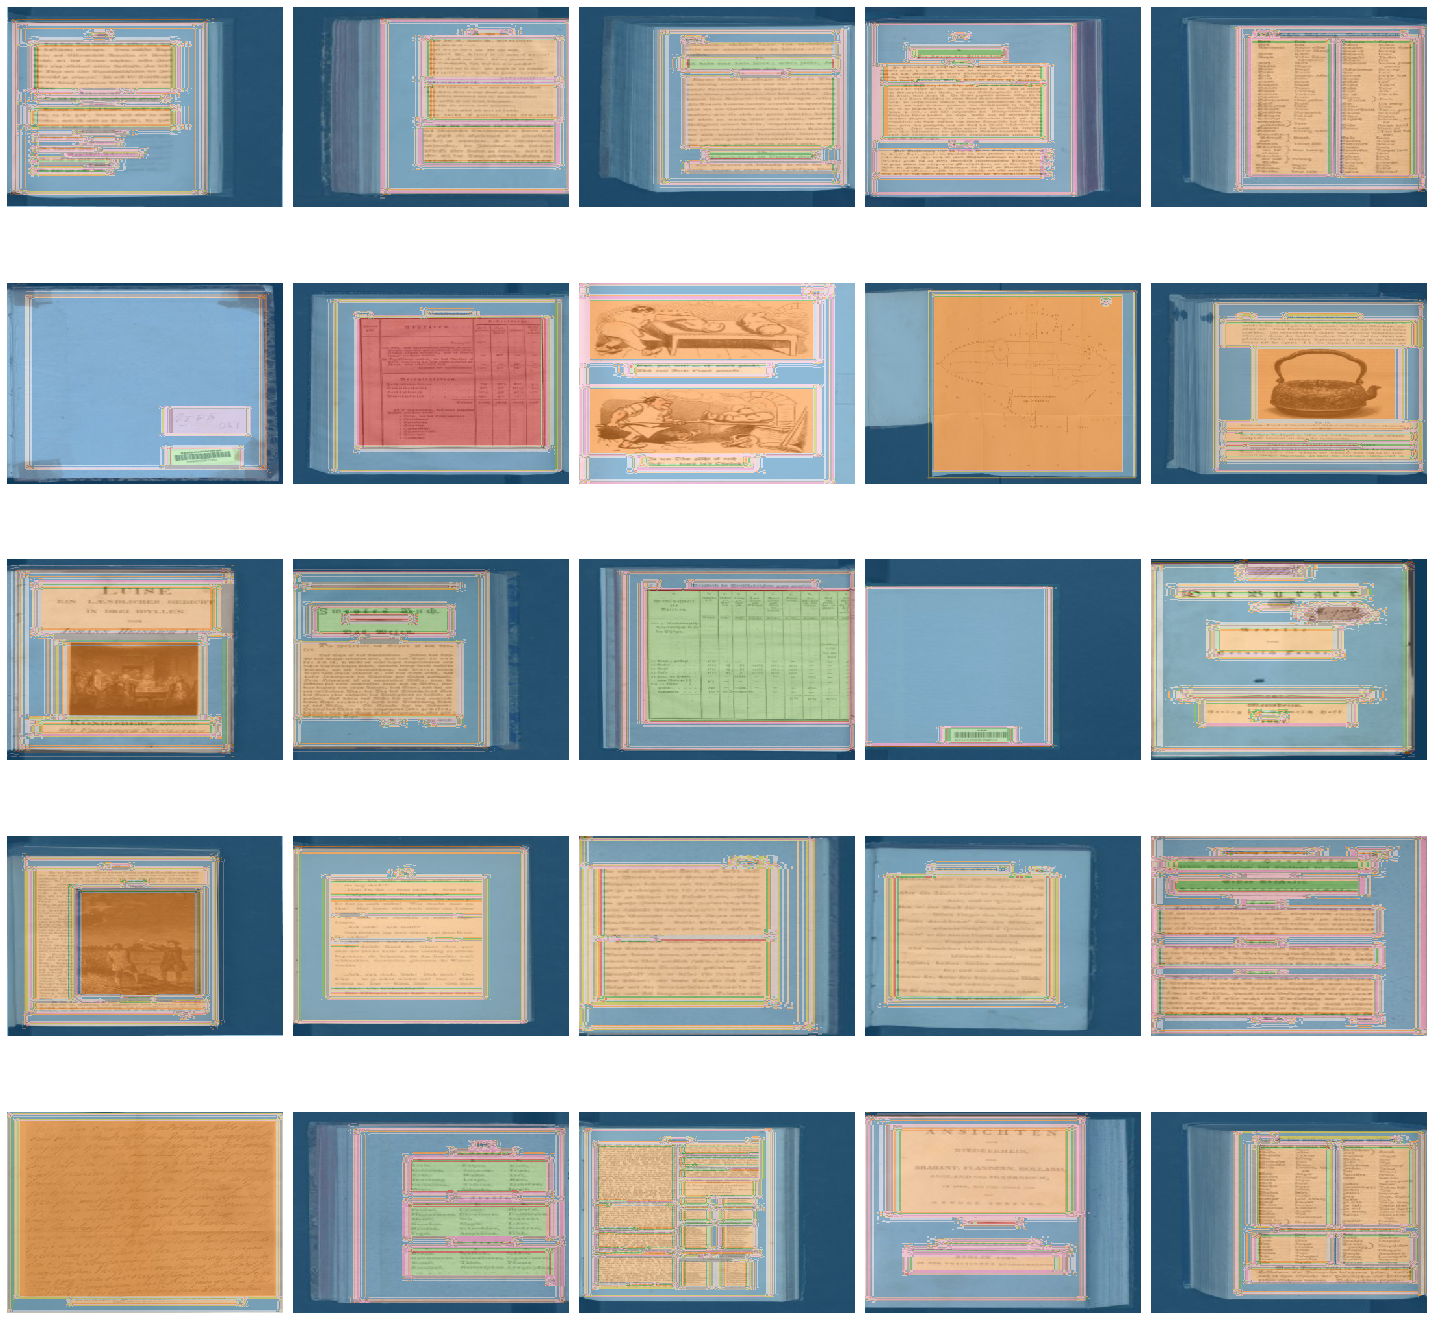

In [387]:
imglist.show_batch()

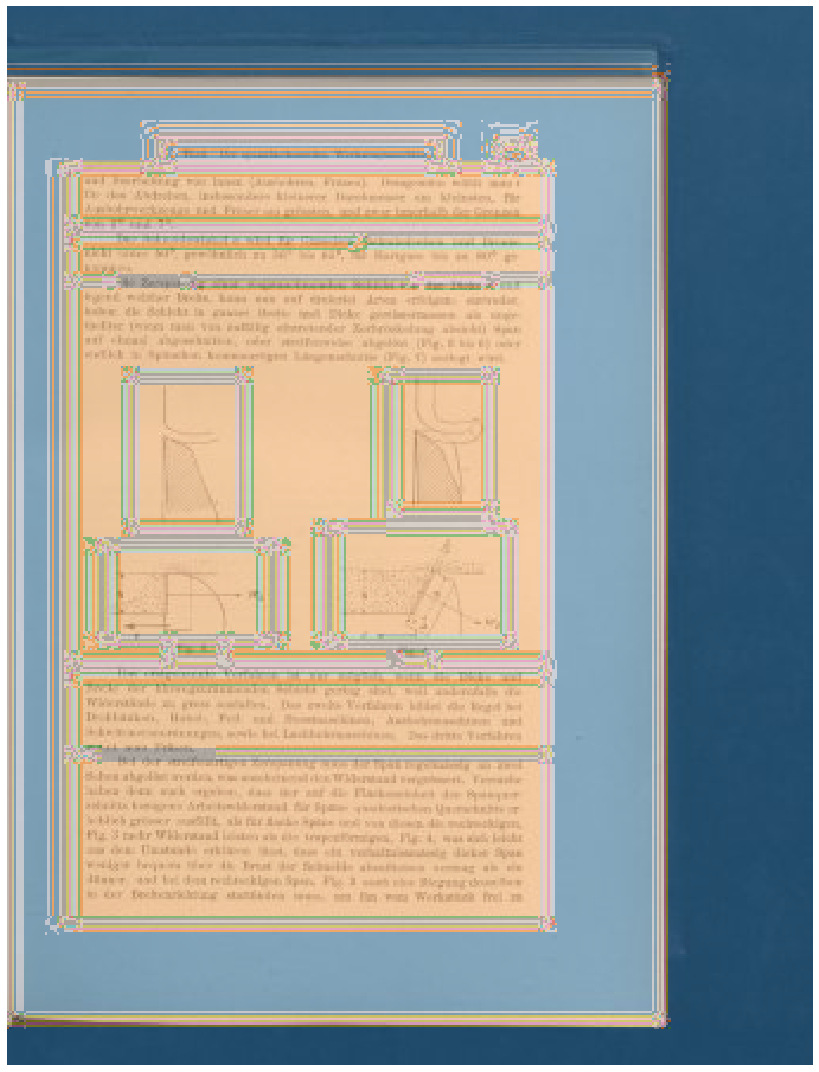

In [388]:
imglist.show_xys(imglist.x[:1], imglist.y[:1], figsize=(15, 15))

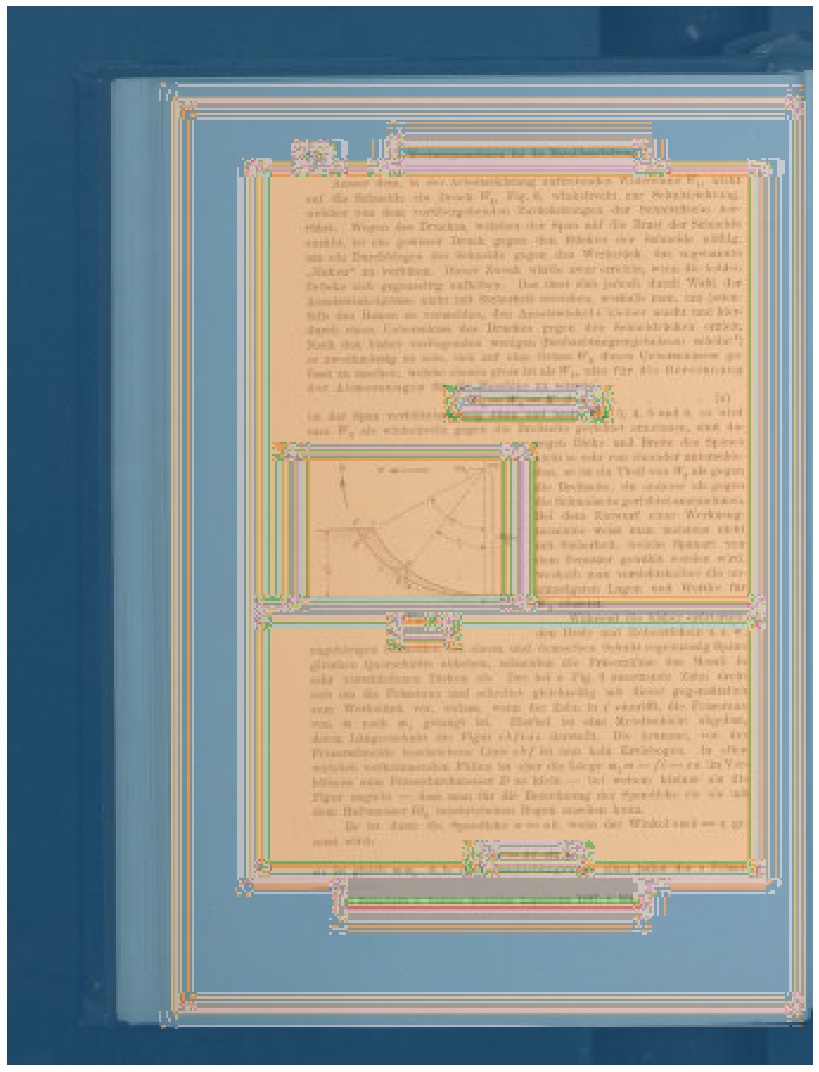

In [389]:
imglist.show_xys(imglist.x[1:2], imglist.y[1:2], figsize=(15, 15))

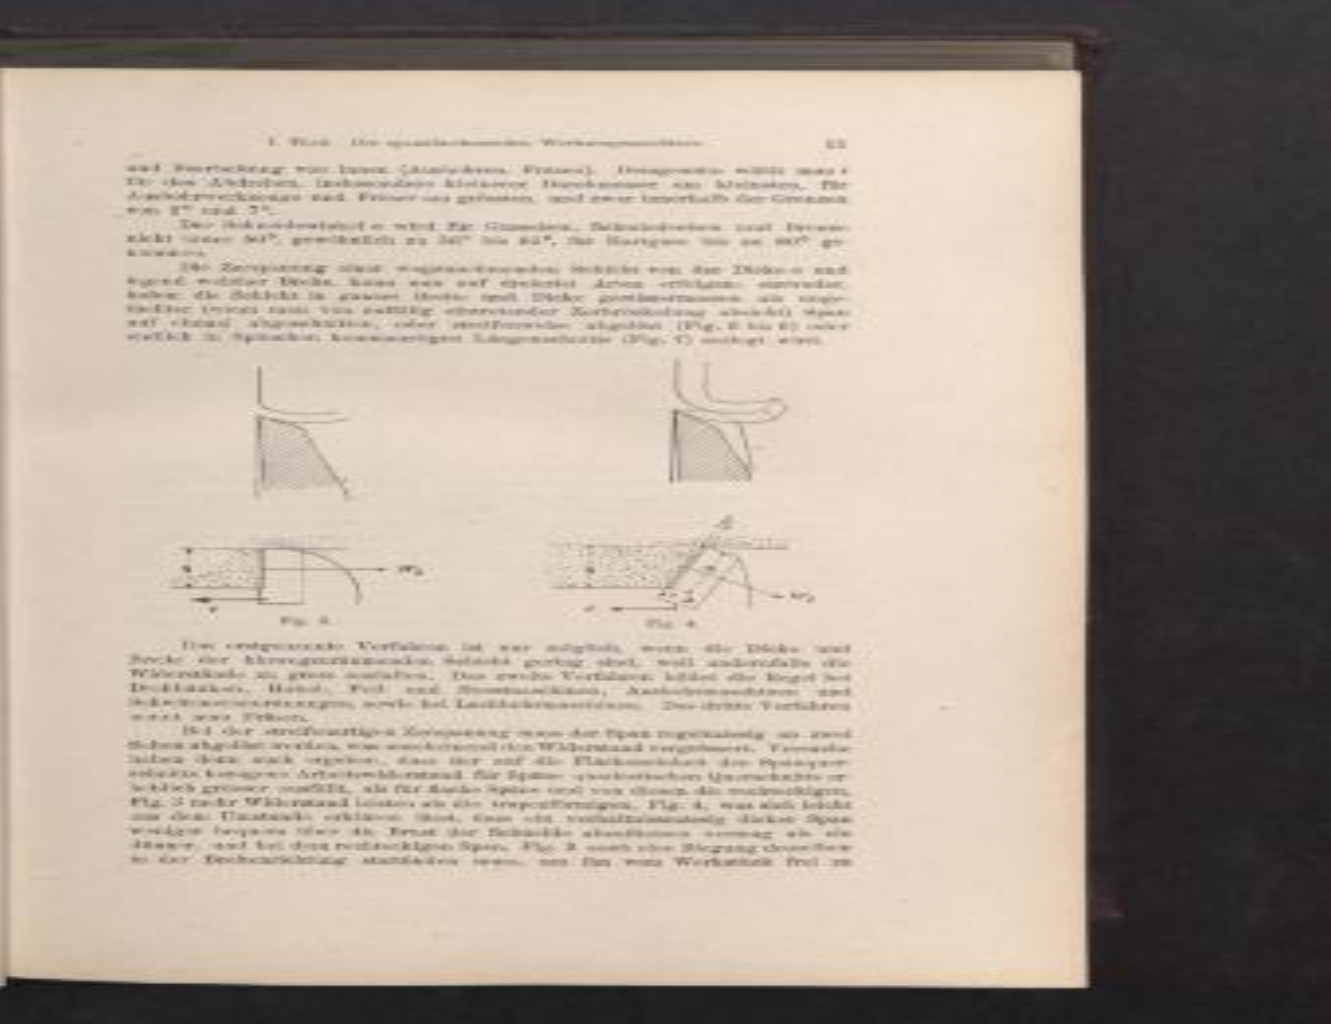

In [390]:
imglist.x[0].resize((3, 1024, int(1024*1.3)))

Maybe not very readable, but should be good enough to try out segmentation. A human would not have a problem here to mark contours of paragraph segments and images or headers (if there were one).

Note to myself: There are some known defects for very small image sizes where models don't work correctly for bigger image sizes. It's an effect known for something like MNIST with 28x28 image sizes (models can't be used for higher resolutions like 200x200 for digit recognition or face detection). I don't think it matters here as the image really is not obfuscated, only the text is a bit blurred. But we don't make text recognition here, so everything should be fine. But we should check it at a later spot in the hackathon.